In this notebook I want to explore what kind of errors are made by the SapBERT_XLMR model when normalizing mentions from the TLC dataset to UMLS


In [1]:
import csv
import json
import re
from collections import Counter
from pathlib import Path

import diskcache as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from tqdm import tqdm

from config import TLCPaths

In [32]:


UMLS_KEY = "43f9234c-4977-45f6-a440-2dda1b43d919"

umls_cache = dc.Cache("caches/umls_error_analysis_cache")


@umls_cache.memoize()
def get_semantic_type_and_group(cui):
    concept_url = f"https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cui}?apiKey={UMLS_KEY}"
    response = requests.get(concept_url)
    try:
        results = response.json()["result"]
    except:
        return set(), set()
    sem_types = set()
    sem_groups = set()
    for sem_type_info in results["semanticTypes"]:
        sem_types.add(sem_type_info["name"])
        type_url = f"{sem_type_info['uri']}?apiKey={UMLS_KEY}"
        type_response = requests.get(type_url)
        type_results = type_response.json()["result"]
        sem_group = type_results["semanticTypeGroup"]['expandedForm']
        sem_groups.add(sem_group)
    return sem_types, sem_groups


@umls_cache.memoize()
def get_synonyms(cui):
    query_url = f"https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cui}/atoms?apiKey={UMLS_KEY}&language=ENG"
    response = requests.get(query_url)
    synonyms = []
    try:
        results = response.json()["result"]
    except:
        return set()
    for result in results:
        if result['language'] == 'ENG':
            synonyms.append(result['name'])
    return set(synonyms)


In [3]:
predictions_file = Path(TLCPaths.project_data_path / "sapbert_predictions.json")
with open(predictions_file, "r") as f:
    all_predictions = json.load(f)

with open(TLCPaths.project_data_path / "TLC_UMLS.json", "r") as f:
    data = json.load(f)
    X = np.array([entry["mention"] for entry in data])
    Y = np.array([entry["cui"] for entry in data])

concept_names, concept_cuis = [], []
with open(TLCPaths.project_data_path / "german_umls_names_and_cuis.csv", newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
        assert len(row) == 2
        concept_cuis.append(row[0])
        concept_names.append(row[1].strip())

In [31]:
@umls_cache.memoize()
def get_atom_uis_for_cui(cui):
    query_url = f"https://uts-ws.nlm.nih.gov/rest/content/current/CUI/{cui}/atoms?apiKey={UMLS_KEY}&language=GER"
    response = requests.get(query_url)
    try:
        results = response.json()["result"]
    except KeyError:
        print('atom ui: ', response.json())
        return []
    uis = []
    for result in results:
        uis.append(result['ui'])
    return uis


@umls_cache.memoize()
def get_parent_ui(ui):
    query_url = f"https://uts-ws.nlm.nih.gov/rest/content/current/AUI/{ui}/parents?apiKey={UMLS_KEY}"
    response = requests.get(query_url)
    try:
        results = response.json()["result"]
    except KeyError:
        return ''
    return results[0]['ui']


@umls_cache.memoize()
def get_child_uis(ui):
    query_url = f"https://uts-ws.nlm.nih.gov/rest/content/current/AUI/{ui}/children?apiKey={UMLS_KEY}"
    response = requests.get(query_url)
    try:
        results = response.json()["result"]
        # print(results)
    except KeyError:
        return []
    parent_uis = []
    for result in results:
        parent_uis.append(result['ui'])
    return parent_uis


@umls_cache.memoize()
def is_parent_or_child(gold_cui, pred_cui):
    if gold_cui == pred_cui:
        return True
    gold_atom_uis = get_atom_uis_for_cui(gold_cui)
    pred_atom_uis = get_atom_uis_for_cui(pred_cui)
    for gold_atom_ui in gold_atom_uis:
        parent_ui = get_parent_ui(gold_atom_ui)
        if parent_ui in pred_atom_uis:
            return True
        child_uis = get_child_uis(gold_atom_ui)
        for child_ui in child_uis:
            if child_ui in pred_atom_uis:
                return True
    return False


# categorize errors by looking at the mentions
def get_error_types(mention, pred_id, gold_id):
    if gold_id == pred_id:
        return {"TP"}

    pred_types, pred_groups = get_semantic_type_and_group(pred_id)
    gold_types, gold_groups = get_semantic_type_and_group(gold_id)
    pred_syns = get_synonyms(pred_id)
    gold_syns = get_synonyms(gold_id)

    error_types = set()
    if not gold_id in concept_cuis:
        error_types.add("MISSING_CUI_GOLD")
    if not pred_id in concept_cuis:
        error_types.add("MISSING_CUI_PRED")

    if len(mention.split(" ")) >= 3:
        error_types.add("COMPLEX_ENTITY")
    if bool(re.match("[A-Z]{2,3}", mention)):
        error_types.add("ABBREV")
    if len(gold_types.intersection(pred_types)) == 0:
        error_types.add("WRONG_SEMANTIC_TYPE")
    if len(gold_groups.intersection(pred_groups)) == 0:
        error_types.add("WRONG_SEMANTIC_GROUP")
    if len(pred_syns.intersection(gold_syns)) > 0:
        error_types.add("SAME_SYNONYMS")
    if is_parent_or_child(gold_id, pred_id):
        error_types.add("PARENT_OR_CHILD")
    return {'UNKNOWN_ERROR'} if len(error_types) == 0 else error_types


is_parent_or_child("C0031676", "C0017881")

True

In [5]:
y_preds = np.array(all_predictions['SAPBERT_mention_cls_token_rep_cls_token_index'])
wrong_top_1_mask = y_preds[:, 0] != Y


In [33]:
error_types = []
for mention, pred, gold in tqdm(list(zip(X, y_preds[:, 0], Y))):
    err_types_single = get_error_types(mention, pred, gold)
    error_types.append(err_types_single)

100%|██████████| 6228/6228 [00:08<00:00, 755.00it/s] 


In [34]:
flat_error_types = [error_type for error_types_single in error_types for error_type in
                    error_types_single]

In [35]:
error_types_df = pd.DataFrame(flat_error_types, columns=["error_type"])

In [36]:
error_value_count = error_types_df.error_type.value_counts().reindex(
    ["ABBREV", "COMPLEX_ENTITY", "SAME_SYNONYMS", "PARENT_OR_CHILD", "UNKNOWN_ERROR",
     "WRONG_SEMANTIC_TYPE", "WRONG_SEMANTIC_GROUP"], fill_value=0)

In [37]:
len(np.unique(X[wrong_top_1_mask])), len(np.unique(X))

(266, 492)

In [38]:
error_value_count

ABBREV                    10
COMPLEX_ENTITY           439
SAME_SYNONYMS            388
PARENT_OR_CHILD          170
UNKNOWN_ERROR           1230
WRONG_SEMANTIC_TYPE     1834
WRONG_SEMANTIC_GROUP    1188
Name: error_type, dtype: int64

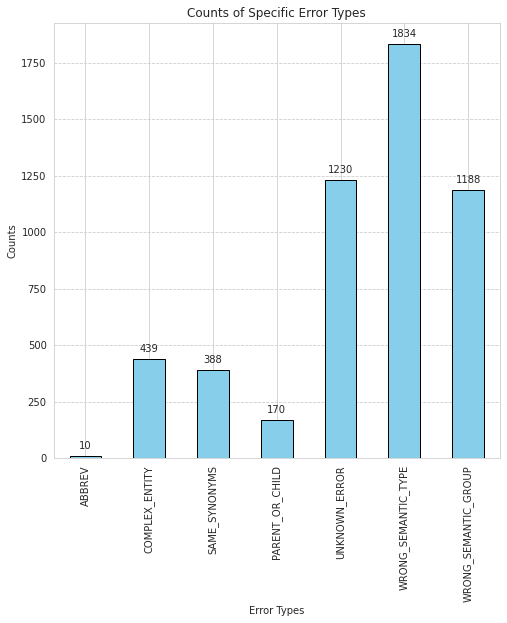

In [59]:
error_counts = error_value_count[
    ["ABBREV", "COMPLEX_ENTITY", "SAME_SYNONYMS", "PARENT_OR_CHILD", "UNKNOWN_ERROR",
     "WRONG_SEMANTIC_TYPE", "WRONG_SEMANTIC_GROUP"]]

# Create the bar plot
ax = error_counts.plot(kind="bar", color='skyblue', edgecolor='black', figsize=(8, 8))

# Add labels and title
plt.xlabel('Error Types')
plt.ylabel('Counts')
plt.title('Counts of Specific Error Types')

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                va='center', xytext=(0, 10), textcoords='offset points')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

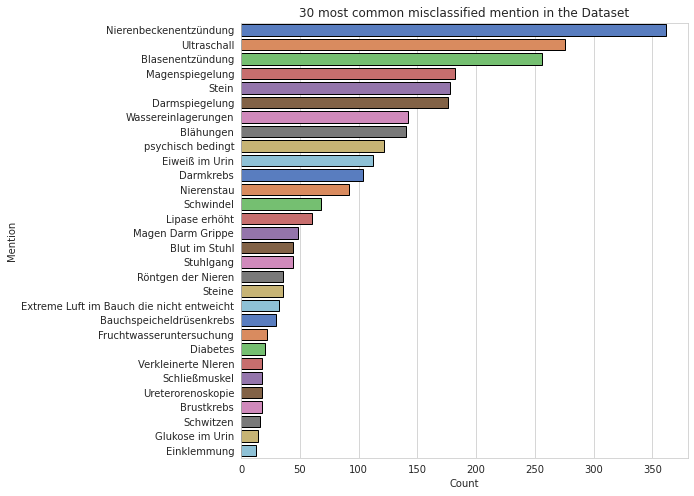

In [61]:
error_mention_count = Counter(X[wrong_top_1_mask])

# Separate the words and their counts
filtered_words, filtered_counts = zip(*error_mention_count.most_common(30))

# Convert the words and counts to a pandas DataFrame
filtered_word_counts_df = pd.DataFrame({
    'Word': filtered_words,
    'Count': filtered_counts
})

# Create a barplot of the word counts using seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Count', y='Word', data=filtered_word_counts_df, errorbar=None, palette='muted',
            orient='h', edgecolor='k')
plt.title('30 most common misclassified mention in the Dataset')
plt.xlabel('Count')
plt.ylabel('Mention')
plt.show()

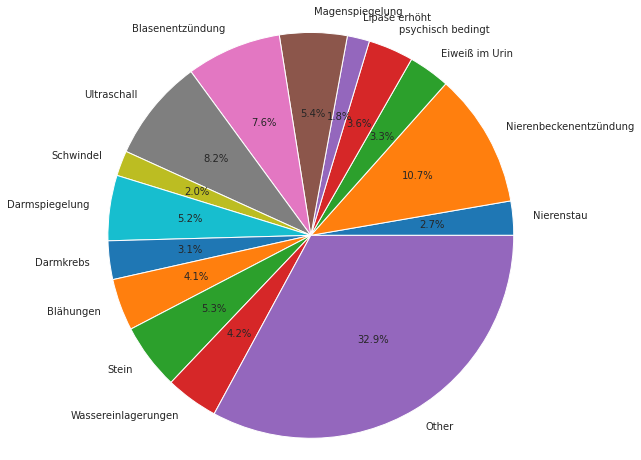

In [62]:
def create_pie_chart(data_dict, palette, minimum_count=10):
    """
    Create a pie chart from a dictionary. Keys with count less than 2 are grouped into 'Other' class.
    Args:
    data_dict: A dictionary where keys are names and values are counts.
    palette: A list of colors for the pie chart.
    """
    # Initialize a new dictionary for grouped data
    grouped_data_dict = {}

    # Initialize a counter for 'Other' class
    other_count = 0

    # Group keys with count less than 2 into 'Other' class
    for name, count in data_dict.items():
        if count < minimum_count:
            other_count += count
        else:
            grouped_data_dict[name] = count

    # Add 'Other' class to the dictionary
    grouped_data_dict['Other'] = other_count

    # Separate the names and their counts
    names, counts = zip(*grouped_data_dict.items())

    # Create a pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(counts, labels=names, colors=palette, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #ax.set_title("Distribution of misclassified mention.")

    plt.show()


# Define a list of hex string colors
hex_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2",
              "#7f7f7f", "#bcbd22", "#17becf"]

create_pie_chart(data_dict=error_mention_count, palette=None, minimum_count=50)

In [63]:
already_printed = set()
unique__error_mention = []
_error_mentions = []
for error_types_single, mention, pred, gold in zip(error_types, X, y_preds[:, 0], Y):
    if pred == gold:
        continue
    for error_type in error_types_single:
        _error_mentions.append(dict(mention=mention, pred_cui=pred, gold_cui=gold,
                                    pred_name=concept_names[concept_cuis.index(pred)],
                                    gold_name=concept_names[concept_cuis.index(gold)],
                                    error_type=error_type))
    if mention in already_printed:
        continue
    # print(mention)
    # print('predicted concept: ', concept_names[concept_cuis.index(pred)], f"({pred})")
    # print('gold concept: ', concept_names[concept_cuis.index(gold)], f"({gold})")
    # print()
    already_printed.add(mention)
    unique__error_mention.append(mention)  #


In [64]:
print(len(unique__error_mention))  # 161 unique unknown errors (out of 3383)

266


In [65]:
error_mentions_df = pd.DataFrame(_error_mentions)
error_mentions_df

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
0,Gallensteine,C0242216,C0008350,Gallensteine,Cholelithiasis,WRONG_SEMANTIC_TYPE
1,Gallensteine,C0242216,C0008350,Gallensteine,Cholelithiasis,PARENT_OR_CHILD
2,Gallensteine,C0242216,C0008350,Gallensteine,Cholelithiasis,SAME_SYNONYMS
3,Gallensteine,C0242216,C0008350,Gallensteine,Cholelithiasis,WRONG_SEMANTIC_GROUP
4,Gallensteine,C0242216,C0008350,Gallensteine,Cholelithiasis,WRONG_SEMANTIC_TYPE
...,...,...,...,...,...,...
5254,Scheide,C0024841,C0042232,Ehe,Vagina,WRONG_SEMANTIC_GROUP
5255,muskelspannung,C0877322,C0026825,Muskelspannung,Schlaffer Muskeltonus,WRONG_SEMANTIC_TYPE
5256,familiaere polycystische Nieren,C0085548,C0022679,"Polyzystische Niere, autosomal-rezessive","Niere, zystische",COMPLEX_ENTITY
5257,Schilddrüsenunterfunktion,C0858730,C0020676,Schilddruesenfunktion erniedrigt,Hypothyreoidismus,WRONG_SEMANTIC_TYPE


In [66]:
error_mentions_df[error_mentions_df.error_type == 'UNKNOWN_ERROR'].drop_duplicates()

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
32,gutartiger Tumor,C0497556,C0086692,gutartige Neubildung,Gutartige Neubildung an nicht naeher bezeichne...,UNKNOWN_ERROR
38,Nierenstau,C4049257,C0178879,Nierenkongestion,obstruktive Uropathie,UNKNOWN_ERROR
61,nicht-bakterielle Blasenentzündungen,C0742964,C0282488,bakterielle Zystitis,"Zystitis, interstitielle",UNKNOWN_ERROR
65,Blinddarmdurchbruch,C0341401,C0854119,Blinddarmperforation,Rupturierte Appendizitis,UNKNOWN_ERROR
76,verschleppte Nierenbeckenentzündung,C0022667,C0085697,Nierenpapillennekrose,chronische Pyelonephritis,UNKNOWN_ERROR
...,...,...,...,...,...,...
2384,Schnarchen,C0037384,C3888880,Schnarchen,Rhonchopathie,UNKNOWN_ERROR
2388,blass,C0678215,C0857322,blass,anaemisch,UNKNOWN_ERROR
2885,keine Kraft,C0004093,C0015672,Asthenie,Ermüdung,UNKNOWN_ERROR
2886,Hausärztin,C1704221,C0017319,Hausärzte,Allgemeinmediziner,UNKNOWN_ERROR


In [67]:
error_mentions_df[error_mentions_df.error_type == 'ABBREV'].drop_duplicates()


,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
857,CT vom Kopf,C0202691,C0936234,Computertomogramm vom Kopf,Röntgencomputertomographie-Scanner,ABBREV
2052,CK,C0201973,C0151576,Kreatinphosphokinase,CK erhoeht,ABBREV
2282,KK,C0202194,C0021682,Kalium,"Versicherung, Kranken-",ABBREV
2874,ABs,C0004057,C0003232,Aspirin,Antibiotika,ABBREV
2900,OP,C0029408,C0543467,Arthrose,"Chirurgische Verfahren, operative",ABBREV
2906,KH,C0202194,C0019994,Kalium,Krankenhäuser,ABBREV


In [68]:
error_mentions_df[error_mentions_df.error_type == 'COMPLEX_ENTITY'].drop_duplicates()


,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
12,Magen Darm Grippe,C0277525,C2242683,Magengrippe,Gastroenteritis durch Norovirus,COMPLEX_ENTITY
24,Blinddarm im März rauskam,C0341401,C0085693,Blinddarmperforation,akute Appendizitis,COMPLEX_ENTITY
25,Teilstückentfernung des Dickdarms,C0009274,C0149750,Kolektomie,Kolektomie partiell,COMPLEX_ENTITY
30,der gesamte Dickdarm entfernt,C0009274,C0192871,Kolektomie,Kolektomie total,COMPLEX_ENTITY
31,Blutergüsse an der Niere,C0392175,C0475022,Nierenblutung,Nierenhaematom,COMPLEX_ENTITY
...,...,...,...,...,...,...
2686,brennen beim wasserlassen,C0235612,C0013428,Brennen der Harnroehre bei Miktion,Dysurie,COMPLEX_ENTITY
2696,Gelbfärbung der Augen,C1141938,C0240962,okulaerer Ikterus,skleraler Ikterus,COMPLEX_ENTITY
2939,Magen Darm Virus,C0949920,C0017160,Norwalk-artige Viren,Gastroenteritis,COMPLEX_ENTITY
2945,Schilddrüse ist in Ordnung,C0740378,C0040132,normale Schilddruesenfunktion,Schilddrüse,COMPLEX_ENTITY


In [69]:
df = error_mentions_df
# Group by 'mention', aggregate 'error_type'
grouped = df.groupby('mention')['error_type'].agg(pd.Series.unique)

# Filter for rows where error_type is 'SAME_SYNONYMS' and only occurs once
filtered_mentions = grouped[grouped.apply(lambda x: len(x) == 1 and x[0] == 'SAME_SYNONYMS')]

# Merge filtered_mentions back with the original DataFrame
result = df[df['mention'].isin(filtered_mentions.index)]

In [70]:
result.drop_duplicates()

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
2389,zittern,C0234369,C0040822,zittern,Tremor,SAME_SYNONYMS
2847,Brustkrebs,C0006142,C0678222,Brustkrebs,Mammakarzinom,SAME_SYNONYMS


In [71]:
df = error_mentions_df
# Group by 'mention', aggregate 'error_type'
grouped = df.groupby('mention')['error_type'].agg(pd.Series.unique)

# Filter for rows where error_type is 'SAME_SYNONYMS' and only occurs once
filtered_mentions = grouped[grouped.apply(lambda x: len(x) == 1 and x[0] == 'PARENT_OR_CHILD')]

# Merge filtered_mentions back with the original DataFrame
result = df[df['mention'].isin(filtered_mentions.index)]
result.drop_duplicates()

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
850,Extrasytsolen,C0340464,C0033036,Kardiale Extrasystoliekomplexe,Atriale Extrasystoliekomplexe,PARENT_OR_CHILD
1585,Darmkrebs,C0346627,C0009402,Krebs des Darms,Kolorektales Karzinom,PARENT_OR_CHILD
1611,Darmkrebs,C0346627,C0007102,Krebs des Darms,Krebs des Kolons,PARENT_OR_CHILD
1752,Zwerchfellbruch,C0019284,C3489393,Hernia diaphragmatica,"Hernie, Hiatus-",PARENT_OR_CHILD
1865,Prostatakrebs,C0376358,C0278838,Prostatakrebs,Prostatakarzinom Rezidiv,PARENT_OR_CHILD
2054,Blasenkrebs,C0005684,C0278827,Harnblasenkrebs,Blasenkrebs Rezidiv,PARENT_OR_CHILD
2238,Hauptschlagader,C0003842,C0003483,Arterien,Aorta,PARENT_OR_CHILD
2290,Gallenstau,C0008370,C0005398,Cholestase,"Gallengangsobstruktion, extrahepatische",PARENT_OR_CHILD
2391,Speiseröhrenkrebs,C0546837,C0152018,Ösophaguskrebs,Karzinom des Ösophagus,PARENT_OR_CHILD
2396,Nierenkrebs,C0740457,C0007134,Krebs der Niere,"Karzinom, Nierenzell-",PARENT_OR_CHILD


In [77]:
df = error_mentions_df
df = df[df["error_type"] != "WRONG_SEMANTIC_TYPE"]
# Group by 'mention', aggregate 'error_type'
grouped = df.groupby('mention')['error_type'].agg(pd.Series.unique)

# Filter for rows where error_type is 'SAME_SYNONYMS' and only occurs once
filtered_mentions = grouped[grouped.apply(lambda x: len(x) == 1 and x[0] == 'WRONG_SEMANTIC_GROUP')]

# Merge filtered_mentions back with the original DataFrame
result = df[df['mention'].isin(filtered_mentions.index)]
result.drop_duplicates()

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
27,Adrenal Fatigue,C0686792,C0001623,Adrenarche,Nebennierenunterfunktion,WRONG_SEMANTIC_GROUP
29,künstlichen befruchung,C4082437,C0733942,"Befruchtung, künstliche",In-vitro-Fertilisation,WRONG_SEMANTIC_GROUP
71,Diätologin,C0012180,C3536818,Diätetik,Diätberater,WRONG_SEMANTIC_GROUP
96,Nakose,C0085349,C0278134,Nosema,Sinnesempfindungsverlust,WRONG_SEMANTIC_GROUP
101,Abspecken,C0444186,C1262477,Abstrichuntersuchung,Gewichtsverlust,WRONG_SEMANTIC_GROUP
105,Stuhl,C0179847,C0015733,Stuhl,Fäzes,WRONG_SEMANTIC_GROUP
113,Pobacke,C1504061,C0006497,Citrullus colocynthis,Gesäß,WRONG_SEMANTIC_GROUP
517,Herzstolpern,C0996952,C0033036,Leonurus,Atriale Extrasystoliekomplexe,WRONG_SEMANTIC_GROUP
629,bluthochdruck,C0005824,C0020538,Blutdruck,Hypertonie,WRONG_SEMANTIC_GROUP
637,einfrieren,C0016701,C0010405,Gefrieren,Kryokonservierung,WRONG_SEMANTIC_GROUP


In [102]:
df = error_mentions_df
# Group by 'mention', aggregate 'error_type'
grouped = df.groupby('mention')['error_type'].agg(pd.Series.unique)

# Filter for rows where error_type is 'SAME_SYNONYMS' and only occurs once
filtered_mentions = grouped[grouped.apply(lambda x: len(x) == 1 and x[0] == 'UNKNOWN_ERROR')]

# Merge filtered_mentions back with the original DataFrame
result = df[df['mention'].isin(filtered_mentions.index)]
result.drop_duplicates()

,mention,pred_cui,gold_cui,pred_name,gold_name,error_type
32,gutartiger Tumor,C0497556,C0086692,gutartige Neubildung,Gutartige Neubildung an nicht naeher bezeichne...,UNKNOWN_ERROR
38,Nierenstau,C4049257,C0178879,Nierenkongestion,obstruktive Uropathie,UNKNOWN_ERROR
61,nicht-bakterielle Blasenentzündungen,C0742964,C0282488,bakterielle Zystitis,"Zystitis, interstitielle",UNKNOWN_ERROR
65,Blinddarmdurchbruch,C0341401,C0854119,Blinddarmperforation,Rupturierte Appendizitis,UNKNOWN_ERROR
76,verschleppte Nierenbeckenentzündung,C0022667,C0085697,Nierenpapillennekrose,chronische Pyelonephritis,UNKNOWN_ERROR
...,...,...,...,...,...,...
2384,Schnarchen,C0037384,C3888880,Schnarchen,Rhonchopathie,UNKNOWN_ERROR
2388,blass,C0678215,C0857322,blass,anaemisch,UNKNOWN_ERROR
2885,keine Kraft,C0004093,C0015672,Asthenie,Ermüdung,UNKNOWN_ERROR
2886,Hausärztin,C1704221,C0017319,Hausärzte,Allgemeinmediziner,UNKNOWN_ERROR
